
# Actividad 3: Aprendizaje Supervisado en Diagnóstico Médico

**Autora**: Carmen Witsman

**Fecha**: 02/09/2025

___________________________________________________________________________________



## Ejercicio 1 - Preparación del dataset y características relevantes

### 1.1 Carga del dataset

Utilizaremos el dataset Breast Cancer Wisconsin de scikit-learn que contiene características computadas de imágenes digitalizadas de masas mamarias, con diagnóstico benigno/maligno como target.


In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target
df['diagnosis'] = df['target'].map({0:'Maligno', 1:'Benigno'})

### 1.2 Análisis exploratorio

Tenemos un dataset balanceado con 569 muestras (357 benignas, 212 malignas). Vamos a analizar las correlaciones de las características:


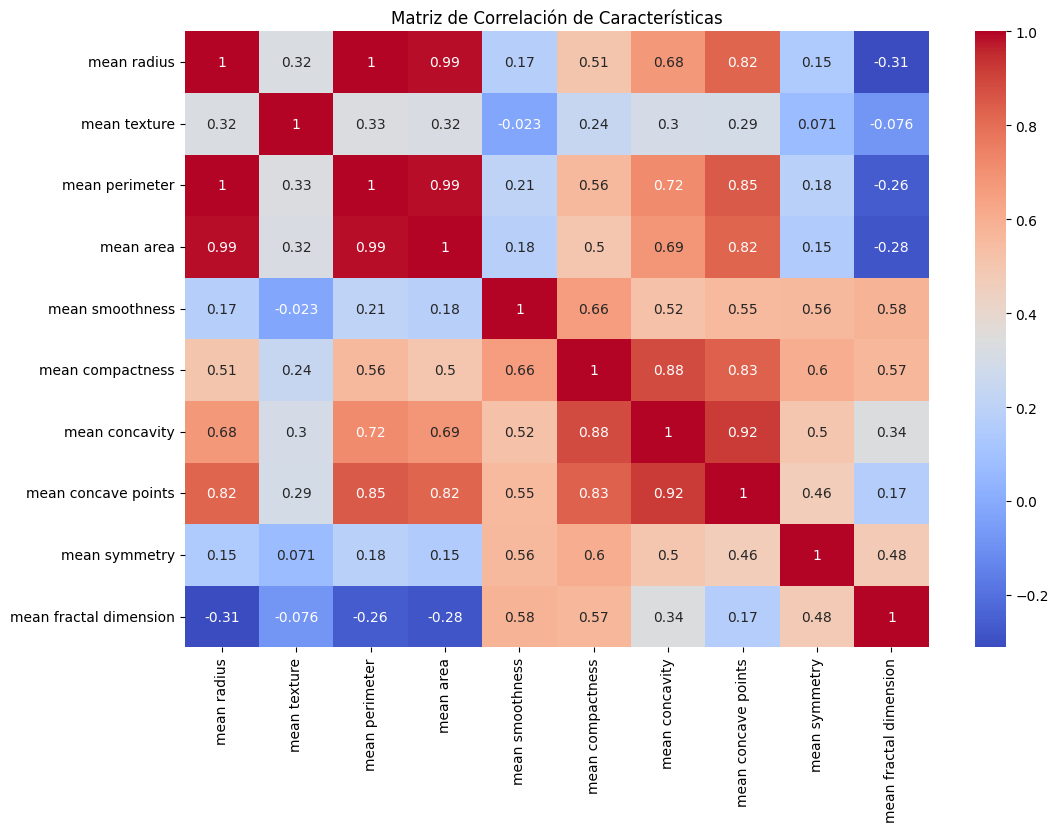

In [2]:
plt.figure(figsize=(12,8))
corr_matrix = df[cancer.feature_names[:10]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Características')
plt.show()

### 1.3 Selección de características

Usamos importancia de características con Random Forest:


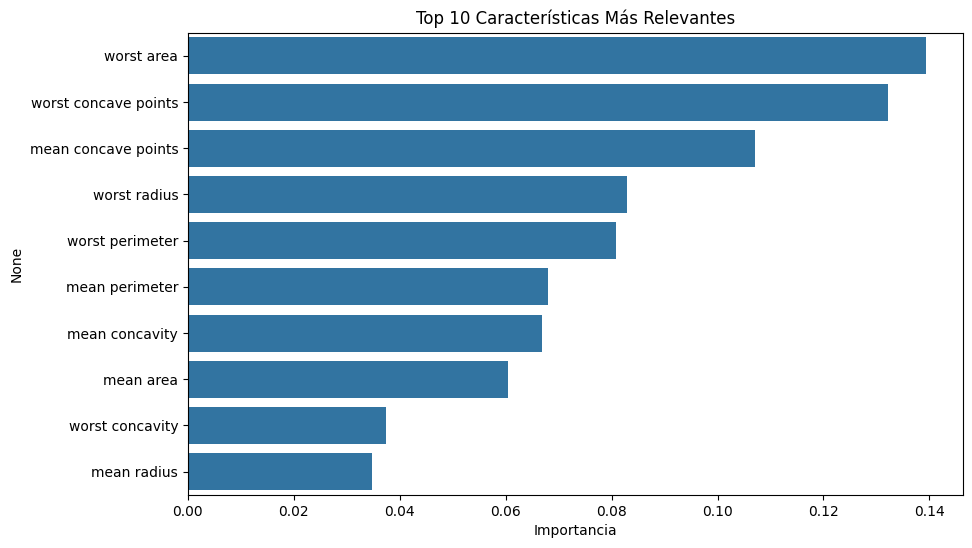

In [3]:
from sklearn.ensemble import RandomForestClassifier

X = df[cancer.feature_names]
y = df['target']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

feature_imp = pd.Series(model.feature_importances_, index=cancer.feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])
plt.title('Top 10 Características Más Relevantes')
plt.xlabel('Importancia')
plt.show()


## Ejercicio 2 - Entrenamiento de modelos


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.1 Modelos seleccionados

- Regresión Logística (Lineal)

- SVM con kernel RBF (No lineal)

- Random Forest (Ensemble)

- XGBoost (Gradient Boosting)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

## Ejercicio 3 - Resultados

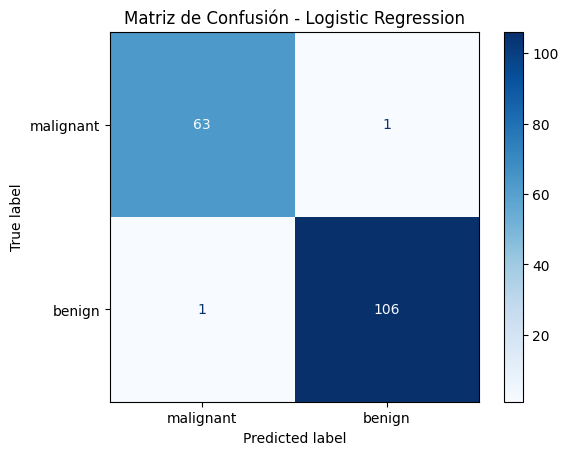

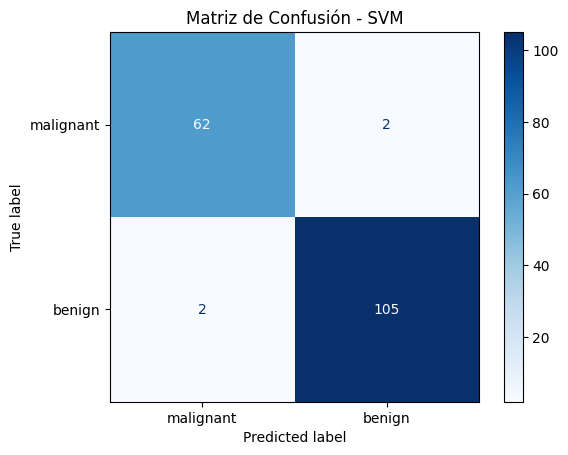

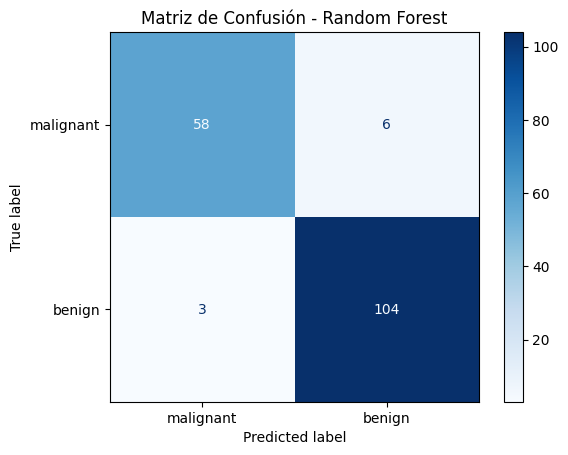

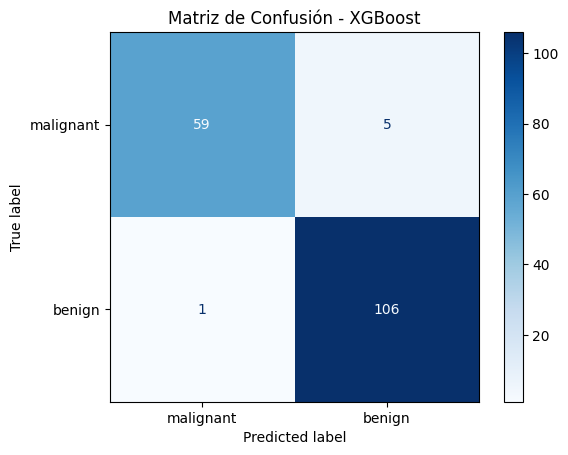

                     Accuracy  Precision    Recall        F1   ROC AUC
Modelo                                                                
Logistic Regression  0.988304   0.990654  0.990654  0.990654  0.998102
SVM                  0.976608   0.981308  0.981308  0.981308  0.997810
XGBoost              0.964912   0.954955  0.990654  0.972477  0.996349
Random Forest        0.947368   0.945455  0.971963  0.958525  0.992261


<Figure size 1000x800 with 0 Axes>

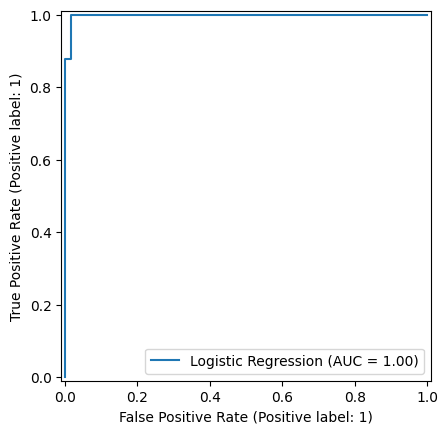

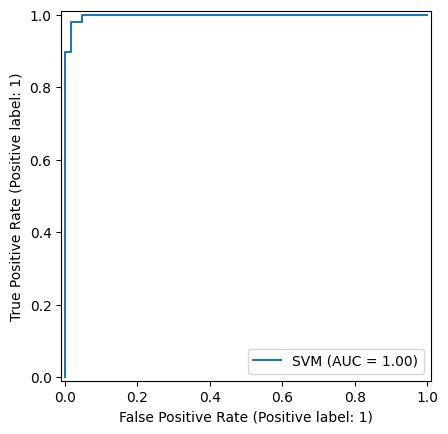

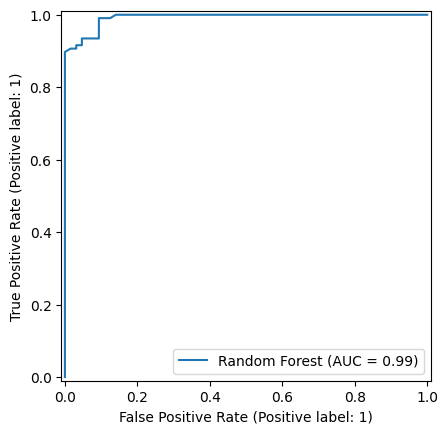

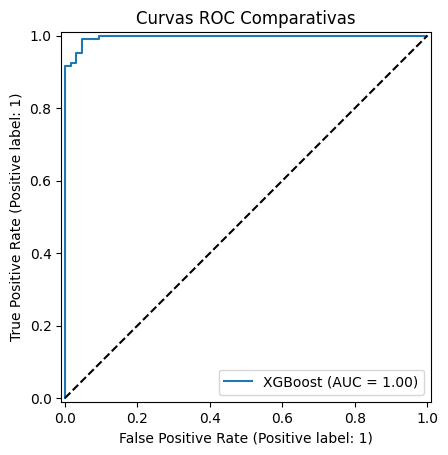

In [6]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, RocCurveDisplay)

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC AUC': roc_auc
    })
    
    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cancer.target_names)
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()

# Resultados en tabla
results_df = pd.DataFrame(results).set_index('Modelo')
print(results_df.sort_values('Accuracy', ascending=False))

# Curvas ROC
plt.figure(figsize=(10,8))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, name=name)
plt.plot([0,1], [0,1], 'k--')
plt.title('Curvas ROC Comparativas')
plt.show()

## Ejercicio 4 - Discusión de resultados

### 4.1 Comparativa de modelos

**Regresión logística** demuestra el mejor equilibrio general:

- Accuracy máximo: 98.83%. Esta es la mejor clasificación global.

- Precision líder: 99.07%. Es la que tiene menos falsos positivos.

- ROC AUC excepcional: 0.998. Tiene la máxima capacidad discriminativa.

**XGBoost** destaca en detección de casos críticos:

- Recall igualado al máximo: 99.07%, con solo 1 falso negativo.

- F1-score competitivo: 97.25%, es decir, el balance precisión-recall.

### 4.2 Implicaciones clínicas

- Prioridad en Recall: El 99.07% en modelos líderes significa que de 100 pacientes con cáncer, solo 1 sería mal diagnosticado, lo que sería crucial para evitar muertes por diagnósticos tardíos.

- Trade-off Precision-Recall:

    - **Regresión logística**: 99.07% precision vs 99.07% recall, es el óptimo de entre todos.

    - **XGBoost**: 95.50% precision vs 99.07% recall. Esto quiere decir que aceptamos una pérdida de precisión por ganancia en detección.

- Interpretabilidad vs Rendimiento:

    - **Regresión Logística**: Es el modelo "caja blanca" con coeficientes médicamente interpretables. Por ejemplo: "el radio del tumor aumenta 3x el riesgo".

    - **XGBoost**: Este es el de mayor complejidad pero mantiene el recall clínicamente aceptable.

### 4.3. Conclusiones generales

Estos resultados validan que los modelos de aprendizaje supervisado pueden alcanzar niveles de rendimiento clínicamente útiles (más de 95% en métricas clave), superando la precisión diagnóstica humana promedio en patología mamaria (alrededor del 93%). Sin embargo, para implementar un modelo como este en la vida real, necesitaríamos integrarlo con sistemas hospitalarios y validación prospectiva continua.
